In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from pmdarima import auto_arima

from xgboost import XGBRegressor

from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings("ignore")

In [125]:
df = pd.read_csv('../data/las-vegas_nv.csv', parse_dates=True, index_col='date').drop(columns=['city', 'state'])
df.sort_index(inplace=True)
df

,humidity (%),precipitation (in),avg_temp (°F),pressure (hPa),wind (mph)
date,,,,,
2021-01-01,57,0.00,47,1016,21
2021-01-02,31,0.00,46,1021,18
2021-01-03,36,0.00,45,1022,6
2021-01-04,36,0.00,47,1021,7
2021-01-05,32,0.00,50,1017,14
...,...,...,...,...,...
2024-03-28,22,0.00,68,1010,29
2024-03-29,17,0.00,63,1008,24
2024-03-30,48,5.30,54,1004,20


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1187 entries, 2021-01-01 to 2024-04-01
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   humidity (%)        1187 non-null   int64  
 1   precipitation (in)  1187 non-null   float64
 2   avg_temp (°F)       1187 non-null   int64  
 3   pressure (hPa)      1187 non-null   int64  
 4   wind (mph)          1187 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 55.6 KB


In [127]:
print(f"Max avg temp between 2021 and 2024 was {round(max(df.loc['2021-01-01':'2024-01-01', 'avg_temp (°F)']), 2)}°F")

Max avg temp between 2021 and 2024 was 105°F


In [128]:
print(f"Avg temp between 2021 and 2024 was {round(df.loc['2021-01-01':'2024-01-01', 'avg_temp (°F)'].mean(), 2)}°F")

Avg temp between 2021 and 2024 was 70.8°F


In [129]:
df.corr()

,humidity (%),precipitation (in),avg_temp (°F),pressure (hPa),wind (mph)
humidity (%),1.000000,0.355072,-0.461786,0.213010,0.006259
precipitation (in),0.355072,1.000000,-0.062982,-0.077631,0.131162
avg_temp (°F),-0.461786,-0.062982,1.000000,-0.513027,0.047056
pressure (hPa),0.213010,-0.077631,-0.513027,1.000000,-0.355062
wind (mph),0.006259,0.131162,0.047056,-0.355062,1.000000


We can notice that humidity and pressure has a strong negative correlation with temperature and as humidity increases, precipitation also increases slightly which is as expected.


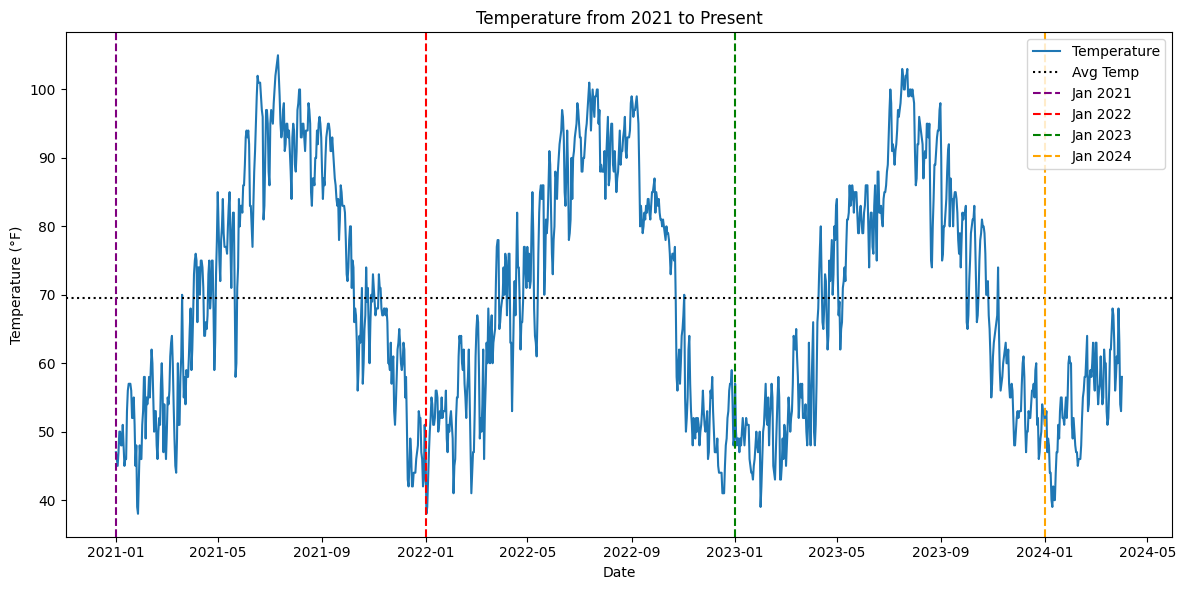

In [130]:
plt.figure(figsize=(12, 6))
sns.lineplot(df['avg_temp (°F)'], label='Temperature')
plt.axhline(df['avg_temp (°F)'].mean(), color='black', linestyle=':', label='Avg Temp')
plt.axvline(pd.to_datetime('2021-01-01'), color='purple', linestyle='--', label='Jan 2021')
plt.axvline(pd.to_datetime('2022-01-01'), color='red', linestyle='--', label='Jan 2022')
plt.axvline(pd.to_datetime('2023-01-01'), color='green', linestyle='--', label='Jan 2023')
plt.axvline(pd.to_datetime('2024-01-01'), color='orange', linestyle='--', label='Jan 2024')
plt.title('Temperature from 2021 to Present')
plt.ylabel('Temperature (°F)')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()

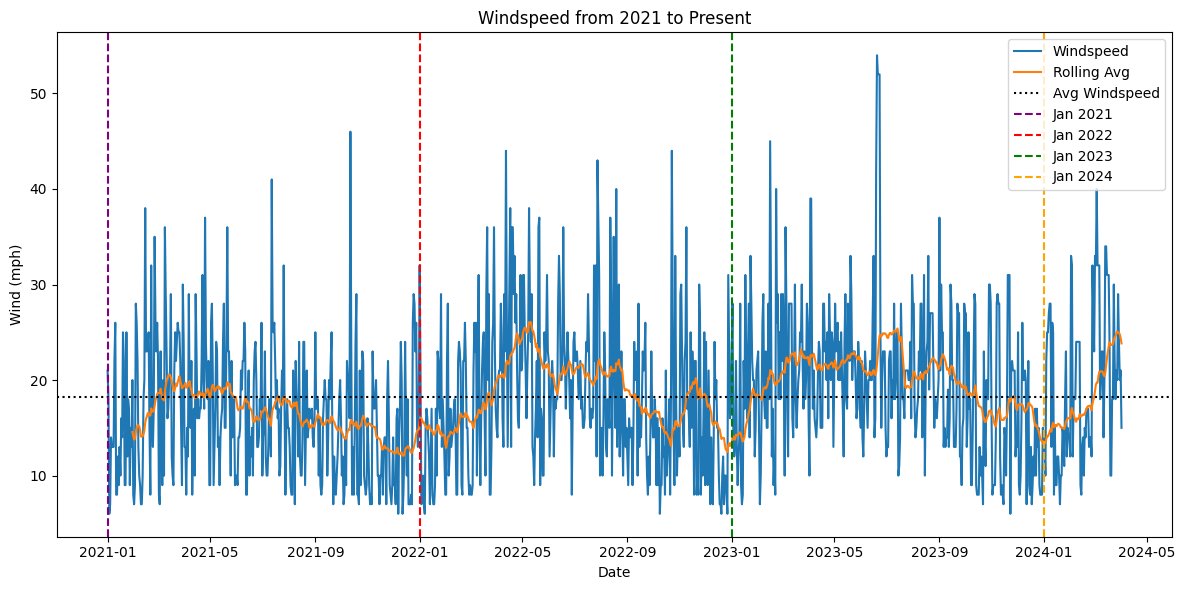

In [131]:
plt.figure(figsize=(12, 6))
sns.lineplot(df['wind (mph)'], label='Windspeed')
sns.lineplot(df["wind (mph)"].rolling(window=30).mean(), label='Rolling Avg')
plt.axhline(df['wind (mph)'].mean(), color='black', linestyle=':', label='Avg Windspeed')
plt.axvline(pd.to_datetime('2021-01-01'), color='purple', linestyle='--', label='Jan 2021')
plt.axvline(pd.to_datetime('2022-01-01'), color='red', linestyle='--', label='Jan 2022')
plt.axvline(pd.to_datetime('2023-01-01'), color='green', linestyle='--', label='Jan 2023')
plt.axvline(pd.to_datetime('2024-01-01'), color='orange', linestyle='--', label='Jan 2024')
plt.title('Windspeed from 2021 to Present')
plt.ylabel('Wind (mph)')
plt.xlabel('Date')
plt.legend(loc= 'upper right')
plt.tight_layout()

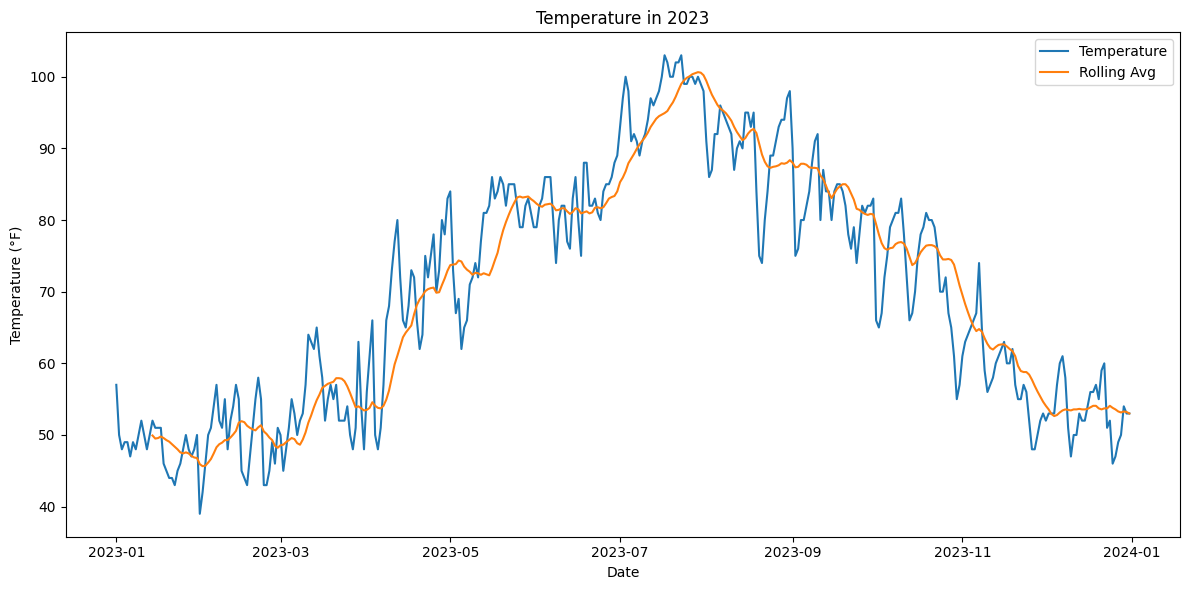

In [132]:
plt.figure(figsize=(12, 6))
sns.lineplot(df.loc['2023', 'avg_temp (°F)'], label='Temperature')
sns.lineplot(df.loc["2023", "avg_temp (°F)"].rolling(window=14).mean(), label='Rolling Avg')
plt.title('Temperature in 2023')
plt.ylabel('Temperature (°F)')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()

---

<h2 align='center'>Prophet</h2>


20:46:38 - cmdstanpy - INFO - Chain [1] start processing
20:46:38 - cmdstanpy - INFO - Chain [1] done processing


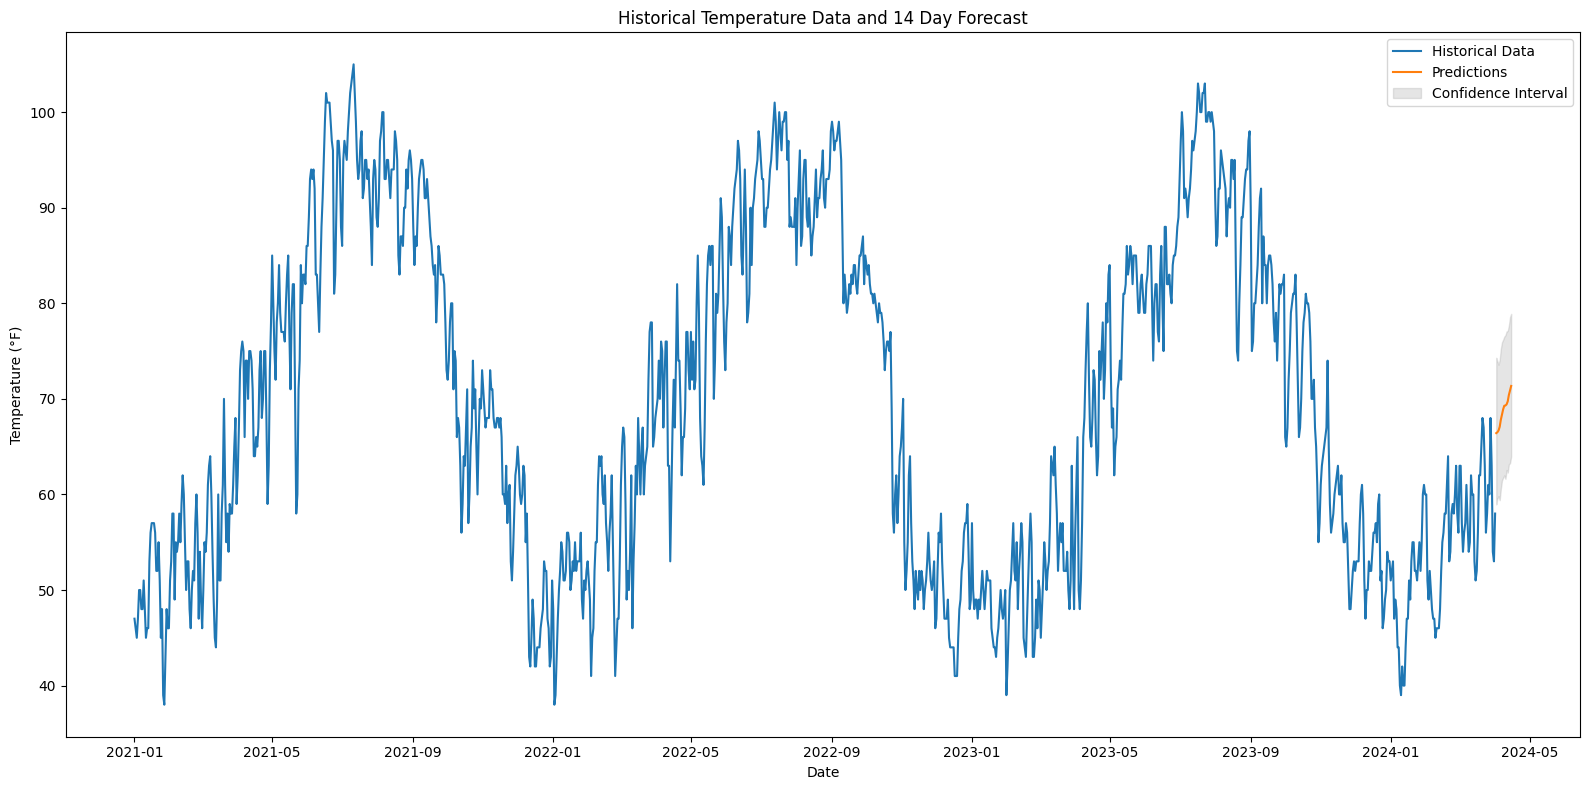

In [133]:
ph_df = df[['avg_temp (°F)']].reset_index()
ph_df.columns = ['ds', 'y']

model = Prophet()
model.fit(ph_df)

periods = 14

future = model.make_future_dataframe(periods=periods, freq='D')
forecast = model.predict(future)

plt.figure(figsize=(16, 8))
plt.plot(ph_df['ds'], ph_df['y'], label='Historical Data')
plt.plot(forecast['ds'][-periods:], forecast['yhat'][-periods:], label='Predictions')
plt.fill_between(forecast['ds'][-periods:], forecast['yhat_lower'][-periods:], forecast['yhat_upper'][-periods:], color='gray', alpha=0.2, label='Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.title('Historical Temperature Data and 14 Day Forecast')
plt.legend()
plt.tight_layout()

In [134]:
y = ph_df['y'][-periods:]
yhat_pred = forecast['yhat'][-periods:]

mse = mean_squared_error(y, yhat_pred)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 91.98557275850533


In [135]:
predicted_dates = forecast['ds'][-periods:]
predicted_values = forecast['yhat'][-periods:]

predicted_df = pd.DataFrame({'Date': predicted_dates, 'predicted_temp': predicted_values})
predicted_df.set_index('Date', inplace=True)
predicted_df

,predicted_temp
Date,
2024-04-02,66.415957
2024-04-03,66.507655
2024-04-04,66.691252
2024-04-05,67.075726
2024-04-06,67.818139
2024-04-07,68.356360
2024-04-08,68.901909
2024-04-09,69.280640
2024-04-10,69.305807


In [136]:
predicted_values = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-periods:]

predicted_values.rename(columns={'ds': 'Date', 'yhat':'predicted_temp', 'yhat_lower':'predicted_temp_lower', 'yhat_upper':'predicted_temp_upper'}, inplace=True)

predicted_values.set_index('Date', inplace=True)
predicted_values

,predicted_temp,predicted_temp_lower,predicted_temp_upper
Date,,,
2024-04-02,66.415957,58.955237,74.302176
2024-04-03,66.507655,59.569620,73.950883
2024-04-04,66.691252,59.819714,73.567773
2024-04-05,67.075726,59.397873,74.098675
2024-04-06,67.818139,60.590333,75.249545
2024-04-07,68.356360,61.474388,75.921035
2024-04-08,68.901909,61.745778,76.190492
2024-04-09,69.280640,61.990232,76.505386
2024-04-10,69.305807,61.634082,76.658838
